<h1 style='background:#C4F1E8; border:2; border-radius: 10px; font-size:250%; font-weight: bold; color:black'><center>Prédictions d'AVC</center></h1> 
 
<img src = "https://www.news-medical.net/image.axd?picture=2021%2F11%2Fshutterstock_1488035675-1.jpg" width = 500 height = 400/>

Pour la culture : 
L’accident vasculaire cérébral (AVC) est la conséquence de l’obstruction ou de la rupture d’un vaisseau transportant le sang dans le cerveau.

Il se traduit par un déficit neurologique d’installation soudaine, qui peut concerner la motricité, la sensibilité, le langage, ou la vision, pour ne citer que les manifestations les plus fréquentes, selon le siège de la lésion cérébrale (Quand y penser?)

Un autre terme utilisé est « attaque cérébrale ».
En anglais, l’AVC est désigné par le terme « stroke ».

<a id="title-five"></a>
<h1 style='background:#C4F1E8; border:2; border-radius: 10px; color:black'><center>Imports des librairies</center></h1>

In [558]:
# Session Spark
from pyspark import SparkContext
from pyspark.sql import SparkSession

# Pandas
import pyspark.pandas as pd

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.types import DoubleType

from matplotlib import pyplot 

**Creation de la Session Spark**

In [559]:
spark = SparkSession.builder.getOrCreate()

<a id="title-five"></a>
<h1 style='background:#C4F1E8; border:2; border-radius: 10px; color:black'><center>Lecture et analyse des données</center></h1>

L'analyse et la lecture de notre jeu de données se fera de manière séquentielle :

- Analyse des features et de leur type
- Détection de données erronées (valeurs null, inutiles, ...)
- L'ampleur des données
- Analyse des facteurs amenant à un AVC

In [560]:
# Lecture du jeu de données
df = spark.read.csv('./brain_stroke.csv', header = True, inferSchema = True).cache()

# Affichage de 5 entités
df.limit(10).toPandas()

# Affichage des features
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



**Analyse des features et de leur type**

- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease 
- ever_married: "No" or "Yes"
- worktype: "children", "Govtjov", "Neverworked", "Private" or "Self-employed"
- Residencetype: "Rural" or "Urban"
- avgglucoselevel: average glucose level in blood
- bmi: body mass index
- smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- stroke: 1 if the patient had a stroke or 0 if not

Après affichage du schéma de notre dataframe, nous nous rendons compte que les colonnes sont de différents type.

Dans le cadre de l'éxécution de notre future pipeline de Machine Learning, il sera vitale de transformer les valeurs non-numérique en valeur numérique.

**Détection de données erronées / inutiles**

In [561]:
df.select("gender").distinct().show()
print("Nombre d'entités avec le gender 'Other' : " + str(df.filter(df["gender"] == 'Other').count()))

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+

Nombre d'entités avec le gender 'Other' : 1


On remarque qu'il existe qu'une seule occurence du gender "other", on retirera donc durant la phase de preprocessing cette occurence afin que les données soient plus équilibrés.

On remarque également qu'il existe une valeur "unknown" pour notre feature "smoking_status".

In [562]:
df.select("smoking_status").distinct().toPandas()

,smoking_status
0,smokes
1,Unknown
2,never smoked
3,formerly smoked


Afin d'équilibrer notre jeu de donnée, il est impératif qu'une quantité exacte d"informations soit disponible pour chaque entité de notre data set, cela dans le but d'augmenter la précision de nos prédictions à venir.

On retirera donc durant la phase de preprocessing les entités avec une valeur de "smoking_status" à "unknown".

On remarque également que la feature "bmi" est de type string qui devraient en fait être des valeurs numériques, il va donc falloir les convertir en double.
Elle contient également des valeurs érronées (N/A) qui va falloir supprimer.

In [563]:
# Type de "bmi"
df.select("bmi").printSchema()

# Valeur erronné (N/A) :
df.select("bmi").show(2)

root
 |-- bmi: string (nullable = true)

+----+
| bmi|
+----+
|36.6|
| N/A|
+----+
only showing top 2 rows



La colonne "id" de notre dataframe sert uniquement d'attribut identifiante, elle n'est en rien un facteur de prédiction, on l'enlèvera donc durant la phase de clean data.

In [564]:
# Type de "bmi"
df.select("id").printSchema()

root
 |-- id: integer (nullable = true)



<a id="title-five"></a>
<h1 style='background:#C4F1E8; border:2; border-radius: 10px; color:black'><center>Visualisation des données</center></h1>

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Répartion des genres parmis les personnes ayant eu un AVC</center></h3>

array([<AxesSubplot: ylabel='count'>], dtype=object)

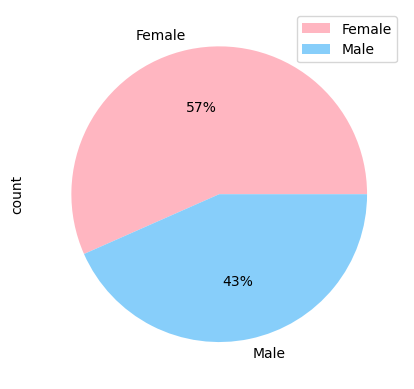

In [565]:
colors = ['lightpink', 'lightskyblue']

pandas_df = df.filter(df['stroke'] == 1).groupBy("stroke", "gender").count().orderBy("stroke").toPandas()
pandas_df.set_index("gender").plot.pie(y="count", colors=colors, autopct='%1.0f%%', subplots=True)

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Répartion des types d'emplois parmis les personnes ayant eu un AVC</center></h3>

array([<AxesSubplot: ylabel='count'>], dtype=object)

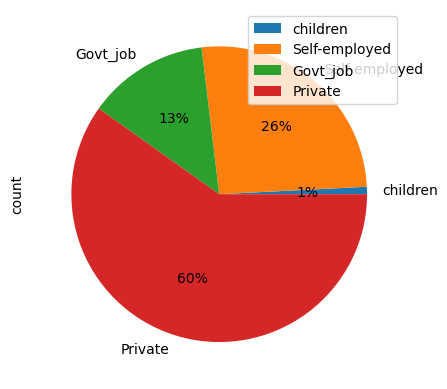

In [566]:
pandas_df = df.filter(df['stroke'] == 1).groupBy("stroke", "work_type").count().orderBy("stroke").toPandas()
pandas_df.set_index("work_type").plot.pie(y="count", subplots=True, autopct='%1.0f%%')

Le stress chronique affecte le système cardiovasculaire, endommageant ainsi les artères au cas où on le laisse passer sans traitement. Le dommage vasculaire peut mener éventuellement à un AVC, qui constitue une urgence médicale provenant d'une artère dans le cerveau qui soit se rompe, soit se bouche.

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Personnes mariées parmis les personnes ayant eu un AVC</center></h3>

array([<AxesSubplot: ylabel='count'>], dtype=object)

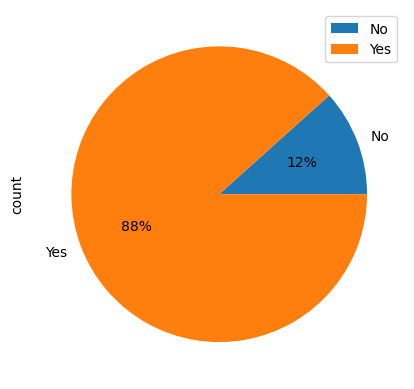

In [567]:
pandas_df = df.filter(df['stroke'] == 1).groupBy("stroke", "ever_married").count().orderBy("stroke").toPandas()
pandas_df.set_index("ever_married").plot.pie(y="count", subplots=True, autopct='%1.0f%%')

![ChessUrl](https://media1.giphy.com/media/jIIduCs5nkq2i2emoS/giphy.gif)

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Répartition des fumeurs/non fumeurs</center></h3>

array([<AxesSubplot: ylabel='count'>], dtype=object)

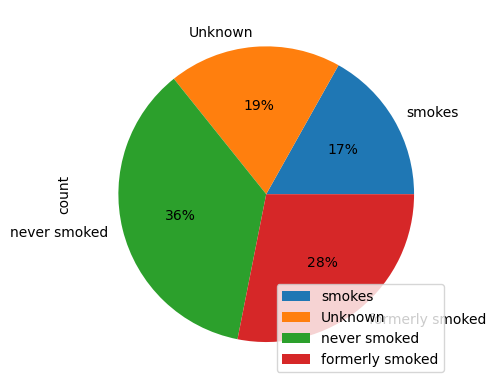

In [568]:
pandas_df = df.filter(df['stroke'] == 1).groupBy("stroke", "smoking_status").count().orderBy("stroke").toPandas()
pandas_df.set_index("smoking_status").plot.pie(y="count", subplots=True, autopct='%1.0f%%')

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Répartition des âges </center></h3>

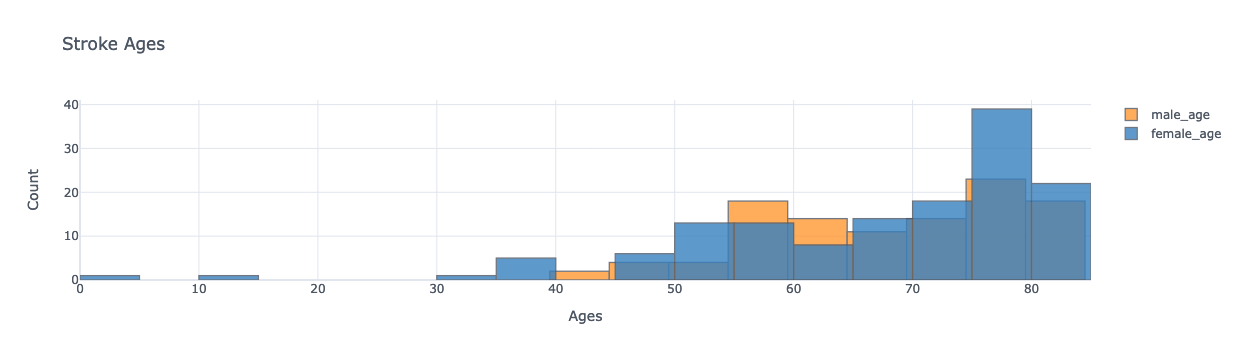

In [570]:
stroke = df.toPandas().loc[df.toPandas()['stroke'] == 1].reset_index()

stroke["male_age"]=stroke[stroke["gender"]=="Male"]["age"]
stroke["female_age"]=stroke[stroke["gender"]=="Female"]["age"]
stroke[["male_age","female_age"]].iplot(kind="histogram", bins=20, theme="white", title="Stroke Ages",
         xTitle='Ages', yTitle='Count')


<a id="title-five"></a>
<h1 style='background:#C4F1E8; border:2; border-radius: 10px; color:black'><center>DATA PREPROCESSING</center></h1>

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Clean data</center></h3>

Comme mentionée plus haut durant la phase d'analyse des données, il est primordiale de supprimer les données erronnés/inutiles.

Egalement, il sera impératif de transformer nos données en données numériques.

Pour cela, il nous sera utile d'utiliser : 

- StringIndexer : il nous servira à convertir les valeurs string binaire (true/false, yes/no, ...) en valeur numérique (0 et 1). Par exemple, la feature "ever_married", les valeurs par défauts sont "yes" et "no", elles seront transformées en 0 et 1.
- OneHotEncoder : il nous servira à construire des matrices binaires pour nos features possédant plusieurs modalités possible. Par exemple, la feature "work_type" peut avoir plusieurs valeurs (Private, Self-employed, Private, Children)
- Vecteur assembleur : il nous servira a obtenir pour chaque entité l'ensemble de leur feature stocké dans une colonne.

Nous entamerons la transformation de notre dataframe en sous-étapes éxécuté dans une pipeline machine learning.

In [537]:
df = df.filter(df["gender"] != "Other")

# Affichage des valeurs possible de "gender" après suppression :
df.select("gender").distinct().toPandas()

,gender
0,Female
1,Male


In [538]:
df = df.filter(df["smoking_status"] != "Unknown")

# Affichage des valeurs possible de "smoking_status" après suppression :
df.select("smoking_status").distinct().toPandas()

,smoking_status
0,smokes
1,never smoked
2,formerly smoked


In [539]:
# Retire les "not applicable" bmi
df = df.filter(df["bmi"] != "N/A")

# Convertir BMI en type double
df = df.withColumn("bmi", df.bmi.cast(DoubleType()))
df.select("bmi").printSchema()

root
 |-- bmi: double (nullable = true)



In [540]:
# On supprime la colonne "id"
df = df.drop("id")

In [541]:
# Vérification de la non-présence de valeurs null
df.toPandas().isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

<a id="title-five"></a>
<h1 style='background:#C4F1E8; border:2; border-radius: 10px; color:black'><center>Construction des modèles</center></h1>

In [542]:
var1 = ['gender', 'ever_married', 'Residence_type', 'work_type', 'smoking_status']
numeric_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

varIdx = [col+'_idx' for col in var1]
stage_1 = StringIndexer(inputCols=var1, handleInvalid='skip', outputCols=varIdx)

varEnc = [col+'_enc' for col in varIdx]
t = ['work_type_idx', 'Residence_type_idx', 'smoking_status_idx']
stage_2 = OneHotEncoder(dropLast=False, inputCols=t, outputCols=['work_type_enc', 'Residence_type_enc', 'smoking_status_enc'])

columns = ['gender_idx', 'ever_married_idx', 'work_type_enc', 'Residence_type_enc', 'smoking_status_enc', 'bmi', 'avg_glucose_level', 'age', 'hypertension', 'heart_disease']
stage_3 = VectorAssembler(inputCols=columns, outputCol='features', handleInvalid="skip")

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Decision Tree</center></h3>

In [556]:
#X = df.drop(['stroke'])
#y = df['stroke']

train, test = df.randomSplit([0.7, 0.3], seed = 23)

from pyspark.ml.classification import DecisionTreeClassifier
tree = DecisionTreeClassifier(labelCol='stroke', featuresCol='features')

model = Pipeline(stages= [stage_1]+[stage_2]+[stage_3]+[tree]).fit(train)
pred_tree = model.transform(test)
pred_tree.select('prediction', 'stroke', 'features').show()

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='stroke', predictionCol='prediction', metricName='accuracy')
accuracy_tree = evaluator.evaluate(pred_tree)

print("Précision de l'arbre de décision : = %g"% (accuracy_tree))
print("Erreur de l'arbre de décision : %g " % (1.0 - accuracy_tree))

+----------+------+--------------------+
|prediction|stroke|            features|
+----------+------+--------------------+
|       0.0|     0|(17,[1,5,8,10,12,...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,5,8,9,12,1...|
|       0.0|     0|(17,[1,5,8,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,3,8,9,12,1...|
|       0.0|     0|(17,[1,5,8,9,12,1...|
|       0.0|     0|(17,[1,5,8,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,5,7,10,12,...|
|       0.0|     0|(17,[1,6,7,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
+----------+------+--------------------+
only showing top

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Random Forest</center></h3>

In [555]:
from pyspark.ml.classification import RandomForestClassifier
random_forest = RandomForestClassifier(featuresCol = 'features', labelCol = 'stroke')

random_forest_model = Pipeline(stages=[stage_1]+[stage_2]+[stage_3]+[random_forest]).fit(train)
predictions_random_forest = random_forest_model.transform(test)
predictions_random_forest.select('prediction', 'stroke', 'features').show()

evaluator = BinaryClassificationEvaluator(labelCol='stroke')
accuracy_rf = evaluator.evaluate(predictions_random_forest)

print("Précision du random forest : = %g"% (accuracy_rf))
print("Erreur du random forest : %g " % (1.0 - accuracy_rf))

+----------+------+--------------------+
|prediction|stroke|            features|
+----------+------+--------------------+
|       0.0|     0|(17,[1,5,8,10,12,...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,5,8,9,12,1...|
|       0.0|     0|(17,[1,5,8,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,3,8,9,12,1...|
|       0.0|     0|(17,[1,5,8,9,12,1...|
|       0.0|     0|(17,[1,5,8,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,5,7,10,12,...|
|       0.0|     0|(17,[1,6,7,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
+----------+------+--------------------+
only showing top

# [StringIndexer](https://medium.com/@nutanbhogendrasharma/role-of-stringindexer-and-pipelines-in-pyspark-ml-feature-b79085bb8a6c)

In [109]:
# The index of string values multiple columns (old code)
# indexers = [
#     StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
#     for c in feature_cat
# ]

# sdf = spark.read.csv(portugaise_bank, header=True, inferSchema=True).cache()
indexer_feature = StringIndexer(inputCols=feature_cat, handleInvalid='skip', outputCols=feature_cat_indexed)
indexer_label = StringIndexer(inputCol=labelCol, handleInvalid='skip', outputCol=labelCol+'_indexed')
# sdf = indexer_feature.fit(sdf).transform(sdf)
# sdf.show(n=1, truncate=False, vertical=True)

# [OneHotEncoder](https://medium.com/@nutanbhogendrasharma/role-of-onehotencoder-and-pipelines-in-pyspark-ml-feature-part-2-3275767e74f0)

In [74]:
# https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib

# The encode of indexed values multiple columns
# encoders = [OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers ]

encoders = OneHotEncoder(dropLast=False, inputCols=feature_cat_indexed, outputCols=feature_cat_encoded)  # handleInvalid='skip',  
# sdf = encoders.fit(sdf).transform(sdf)
sdf.select(feature_cat_indexed+feature_cat_encoded).show(n=2, truncate=False, vertical=True)


-RECORD 0-----------------------------------
 job_indexed               | 1.0            
 marital_indexed           | 0.0            
 education_indexed         | 1.0            
 default_indexed           | 0.0            
 housing_indexed           | 0.0            
 loan_indexed              | 0.0            
 contact_indexed           | 1.0            
 poutcome_indexed          | 0.0            
 job_indexed_encoded       | (12,[1],[1.0]) 
 marital_indexed_encoded   | (3,[0],[1.0])  
 education_indexed_encoded | (4,[1],[1.0])  
 default_indexed_encoded   | (2,[0],[1.0])  
 housing_indexed_encoded   | (2,[0],[1.0])  
 loan_indexed_encoded      | (2,[0],[1.0])  
 contact_indexed_encoded   | (3,[1],[1.0])  
 poutcome_indexed_encoded  | (4,[0],[1.0])  
-RECORD 1-----------------------------------
 job_indexed               | 2.0            
 marital_indexed           | 1.0            
 education_indexed         | 0.0            
 default_indexed           | 0.0            
 housing_i

# VectorAssembler

In [96]:
# Vectorizing encoded values
# assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="rawFeatures")

sdf = spark.read.csv(portugaise_bank, header=True, inferSchema=True).cache()
assembler = VectorAssembler(inputCols=feature_cat_encoded+feature_numeric, outputCol='features')

# assembler.transform(sdf).select(feature_cat+feature_numeric+feature_cat_encoded+['features']).show(n=2, truncate=False, vertical=True)

22/07/17 13:46:40 WARN CacheManager: Asked to cache already cached data.


# Pipeline

In [110]:
sdf = spark.read.csv(portugaise_bank, header=True, inferSchema=True).cache()

Pipeline(stages= [indexer_feature]+[indexer_label]+[encoders]+[assembler]).fit(sdf).transform(sdf).show(n=1, truncate=False, vertical=True)

22/07/17 14:05:47 WARN CacheManager: Asked to cache already cached data.
-RECORD 0------------------------------------------------------------------------------------------------------------------------------
 age                       | 58                                                                                                        
 job                       | management                                                                                                
 marital                   | married                                                                                                   
 education                 | tertiary                                                                                                  
 default                   | no                                                                                                        
 balance                   | 2143                                                                              

In [84]:
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- Target: string (nullable = true)
 |-- job_indexed: double (nullable = false)
 |-- marital_indexed: double (nullable = false)
 |-- education_indexed: double (nullable = false)
 |-- default_indexed: double (nullable = false)
 |-- housing_indexed: double (nullable = false)
 |-- loan_indexed: double (nullable = false)
 |-- contact_indexed: double (nullable = false)
 |-- pou

# randomSplit

In [91]:
# sdf = spark.read.csv(portugaise_bank, header=True, inferSchema=True).cache()
train, test = sdf.randomSplit([0.7, 0.3],seed = 11)
train.show(n=1, truncate=False, vertical=True)
test.show(n=1, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------
 age                       | 18                                                               
 job                       | student                                                          
 marital                   | single                                                           
 education                 | primary                                                          
 default                   | no                                                               
 balance                   | 608                                                              
 housing                   | no                                                               
 loan                      | no                                                               
 contact                   | cellular                                                         
 day                       | 12                   

-RECORD 0-------------------------------------------------------------------------------------
 age                       | 18                                                               
 job                       | student                                                          
 marital                   | single                                                           
 education                 | unknown                                                          
 default                   | no                                                               
 balance                   | 3                                                                
 housing                   | no                                                               
 loan                      | no                                                               
 contact                   | cellular                                                         
 day                       | 25                   

# Classification Algorithms from Spark ML

* LogisticRegression
* DecisionTreeClassifier
* RandomForestClassifier
* Gradient-boosted tree classifier
* NaiveBayes
* Support Vector Machine

In [138]:
# from pyspark.ml.classification import LogisticRegression

# lr = LogisticRegression(labelCol='Target_indexed', featuresCol='features')

# train, test = spark.read.csv(portugaise_bank, header=True, inferSchema=True) \
#     .cache() \
#     .randomSplit([0.7, 0.3], seed = 11)

# train.cache(), test.cache()

# model = Pipeline(stages= [indexer_feature]+[indexer_label]+[encoders]+[assembler]+[lr]).fit(train)
# pred_lr = model.transform(test)
# pred_lr.select('prediction', 'Target_indexed', 'features').show()
pred_lr.show(n=1, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------
 age                       | 18                                                                                                      
 job                       | student                                                                                                 
 marital                   | single                                                                                                  
 education                 | unknown                                                                                                 
 default                   | no                                                                                                      
 balance                   | 3                                                                                                       
 housing                   | no                               

# Evaluation

In [149]:
# evaluator = MulticlassClassificationEvaluator(labelCol='Target_indexed', predictionCol='prediction', metricName='accuracy')
# accuracy_lr = evaluator.evaluate(pred_lr)  # 90.01 %  
# print("Accuracy of LogisticRegression is = %g"% (accuracy_lr))
# print("Error of LogisticRegression = %g " % (1.0 - accuracy_lr))

# model_lr = model.stages[-1]
# print('accuracy lr : ', model_lr.summary.accuracy) 

# model_lr.summary.roc.show(5)
print('areaUnderROC lr : ', model_lr.summary.areaUnderROC)
model_lr_roc = model_lr.summary.roc.toPandas()
# model_lr_roc.plot.scatter(x='FPR', y='TPR')

areaUnderROC lr :  0.8917591386123518


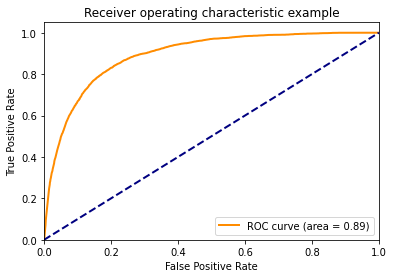

In [150]:
plt.figure()
lw = 2
plt.plot(model_lr_roc['FPR'], model_lr_roc['TPR'], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % model_lr.summary.areaUnderROC)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Evaluation avec handyspark (+ pratique)
# pred_lr.select('probability', 'Target_indexed').collect()
bcm = BinaryClassificationMetrics(pred_lr, scoreCol='probability', labelCol='Taget_indexed')

# bcm.

# Decision Tree

In [134]:
from pyspark.ml.classification import DecisionTreeClassifier
tree = DecisionTreeClassifier(labelCol='Target_indexed', featuresCol='features')

model = Pipeline(stages= [indexer_feature]+[indexer_label]+[encoders]+[assembler]+[tree]).fit(train)
pred_tree = model.transform(test)
pred_tree.select('prediction', 'Target_indexed', 'features').show()

accuracy_tree = evaluator.evaluate(pred_tree)  # 90.01 %  
print("Accuracy of DecisionTree is = %g"% (accuracy_tree))
print("Error of DecisionTree = %g " % (1.0 - accuracy_tree))


# va = model.stages[-2]  # assembler 
# model_tree = model.stages[-1]

# get rules ? 
tree._call_java('rootNode').toString()
# l'arbre sous format visuel
print(model_tree.toDebugString)

# variables importances ? 
# list(zip(va.getInputCols(), model_tree.featureImportances))

+----------+--------------+--------------------+
|prediction|Target_indexed|            features|
+----------+--------------+--------------------+
|       0.0|           1.0|(38,[10,13,18,19,...|
|       0.0|           0.0|(38,[10,13,18,19,...|
|       0.0|           0.0|(38,[10,13,18,19,...|
|       0.0|           0.0|(38,[10,13,17,19,...|
|       0.0|           0.0|(38,[10,13,17,19,...|
|       0.0|           1.0|(38,[10,13,17,19,...|
|       0.0|           0.0|(38,[10,13,17,19,...|
|       0.0|           1.0|(38,[10,13,17,19,...|
|       0.0|           0.0|(38,[10,13,15,19,...|
|       0.0|           1.0|(38,[10,13,15,19,...|
|       0.0|           1.0|(38,[10,13,15,19,...|
|       0.0|           0.0|(38,[10,13,15,19,...|
|       0.0|           0.0|(38,[10,13,15,19,...|
|       0.0|           0.0|(38,[10,13,15,19,...|
|       0.0|           0.0|(38,[10,13,18,19,...|
|       0.0|           0.0|(38,[10,13,18,19,...|
|       0.0|           0.0|(38,[3,13,15,19,2...|
|       0.0|        

AttributeError: 'DecisionTreeClassificationModel' object has no attribute 'summary'

In [ ]:
dt_accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTreeClassifier is = %g"% (dt_accuracy))
print("Test Error of DecisionTreeClassifier = %g " % (1.0 - dt_accuracy))

Accuracy of DecisionTreeClassifier is = 1
Test Error of DecisionTreeClassifier = 0

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = DecisionTreeClassifier(labelCol="loan_indexed", featuresCol="rawFeatures")
rf_model = rf.fit(trainingData)
rf_prediction = rf_model.transform(testData)
rf_prediction.select("prediction", "loan_indexed", "rawFeatures").show()

+----------+------------+--------------------+
prediction|loan_indexed| rawFeatures|
+----------+------------+--------------------+
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 1.0| 1.0|(32,[3,13,15,19,2...|
 0.0| 0.0|(32,[1,13,15,19,2...|
 0.0| 0.0|(32,[1,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[3,13,15,19,2...|
 1.0| 1.0|(32,[1,12,17,19,2...|
 1.0| 1.0|(32,[0,13,16,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
+----------+------------+--------------------+
only showing top 20 rows

In [ ]:
rf_accuracy = evaluator.evaluate(rf_prediction)
print("Accuracy of RandomForestClassifier is = %g"% (rf_accuracy))
print("Test Error of RandomForestClassifier  = %g " % (1.0 - rf_accuracy))

Accuracy of RandomForestClassifier is = 1
Test Error of RandomForestClassifier = 0

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="loan_indexed", featuresCol="rawFeatures",maxIter=10)
gbt_model = gbt.fit(trainingData)
gbt_prediction = gbt_model.transform(testData)
gbt_prediction.select("prediction", "loan_indexed", "rawFeatures").show()

+----------+------------+--------------------+
prediction|loan_indexed| rawFeatures|
+----------+------------+--------------------+
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 1.0| 1.0|(32,[3,13,15,19,2...|
 0.0| 0.0|(32,[1,13,15,19,2...|
 0.0| 0.0|(32,[1,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[3,13,15,19,2...|
 1.0| 1.0|(32,[1,12,17,19,2...|
 1.0| 1.0|(32,[0,13,16,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
+----------+------------+--------------------+
only showing top 20 rows

In [ ]:
gbt_accuracy = evaluator.evaluate(gbt_prediction)
print("Accuracy of Gradient-boosted tree classifie is = %g"% (gbt_accuracy))
print("Test Error of Gradient-boosted tree classifie %g"% (1.0 - gbt_accuracy))

Accuracy of Gradient-boosted tree classifie is = 1
Test Error of Gradient-boosted tree classifie 0

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="loan_indexed", featuresCol="rawFeatures")
nb_model = nb.fit(trainingData)
nb_prediction = nb_model.transform(testData)
nb_prediction.select("prediction", "loan_indexed", "rawFeatures").show()

+----------+------------+--------------------+
prediction|loan_indexed| rawFeatures|
+----------+------------+--------------------+
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 1.0| 1.0|(32,[3,13,15,19,2...|
 0.0| 0.0|(32,[1,13,15,19,2...|
 0.0| 0.0|(32,[1,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[3,13,15,19,2...|
 1.0| 1.0|(32,[1,12,17,19,2...|
 1.0| 1.0|(32,[0,13,16,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
+----------+------------+--------------------+
only showing top 20 rows

In [ ]:
nb_accuracy = evaluator.evaluate(nb_prediction)
print("Accuracy of NaiveBayes is  = %g"% (nb_accuracy))
print("Test Error of NaiveBayes  = %g " % (1.0 - nb_accuracy))

Accuracy of NaiveBayes is = 1
Test Error of NaiveBayes = 0

In [ ]:
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(labelCol="loan_indexed", featuresCol="rawFeatures")
svm_model = svm.fit(trainingData)
svm_prediction = svm_model.transform(testData)
svm_prediction.select("prediction", "loan_indexed", "rawFeatures").show()

+----------+------------+--------------------+
prediction|loan_indexed| rawFeatures|
+----------+------------+--------------------+
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 1.0| 1.0|(32,[3,13,15,19,2...|
 0.0| 0.0|(32,[1,13,15,19,2...|
 0.0| 0.0|(32,[1,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[3,13,15,19,2...|
 1.0| 1.0|(32,[1,12,17,19,2...|
 1.0| 1.0|(32,[0,13,16,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,17,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,15,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
 0.0| 0.0|(32,[7,13,18,19,2...|
+----------+------------+--------------------+
only showing top 20 rows

In [ ]:
svm_accuracy = evaluator.evaluate(svm_prediction)
print("Accuracy of Support Vector Machine is = %g"% (svm_accuracy))
print("Test Error of Support Vector Machine = %g " % (1.0 - svm_accuracy))

Accuracy of Support Vector Machine is = 1
Test Error of Support Vector Machine = 0